In [1]:
from scipy.stats import binom,nbinom,beta
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [2]:
from scipy.stats import binom,nbinom,beta
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [125]:
n = 40
r=1
p=(-r+np.sqrt(r**2+4*r*n))/(2*n)
p=.16
print("p = {}".format(p))
N=10

X_binom = binom(n,p).rvs(N)
X_nbinom = nbinom(r,p).rvs(N)
S_binom = np.sum(X_binom)
S_nbinom = np.sum(X_nbinom)
S_binom_theoric = n*p*N
S_nbinom_theoric = r*(1-p)/p*N
print()
print("Empirical sum: binom: {}, nbinom: {}".format(S_binom,S_nbinom))
print("Theoric sum: binom: {}, nbinom: {}".format(S_binom_theoric,S_nbinom_theoric))

print("Theorique 95% Quantile : binom: {}, nbinom: {}".format(binom(n,p).ppf(.99),nbinom(r,p).ppf(.99)))


p = 0.16

Empirical sum: binom: 60, nbinom: 21
Theoric sum: binom: 64.0, nbinom: 52.5
Theorique 95% Quantile : binom: 12.0, nbinom: 26.0


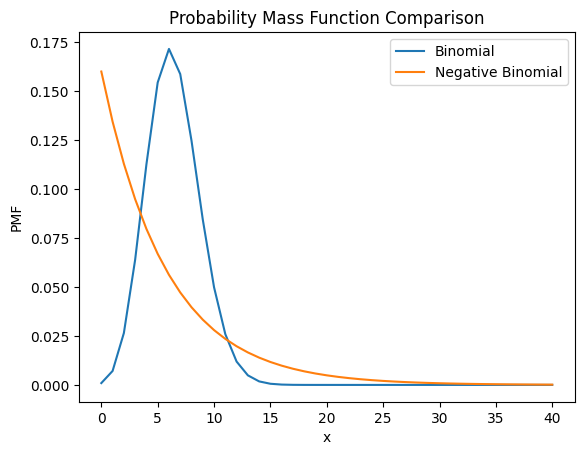

7

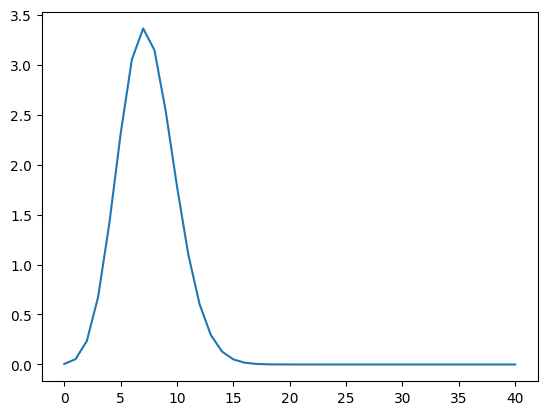

In [127]:

x = np.arange(0, n+1)
binom_pmf = binom.pmf(x, n, p)
nbinom_pmf = nbinom.pmf(x, r, p)

plt.plot(x, binom_pmf, label='Binomial')
plt.plot(x, nbinom_pmf, label='Negative Binomial')
plt.xlabel('x')
plt.ylabel('PMF')
plt.title('Probability Mass Function Comparison')
plt.legend()
plt.show()

plt.plot(x,binom_pmf/nbinom_pmf,label='Binomial/Negative Binomial')
np.argmax(binom_pmf/nbinom_pmf)

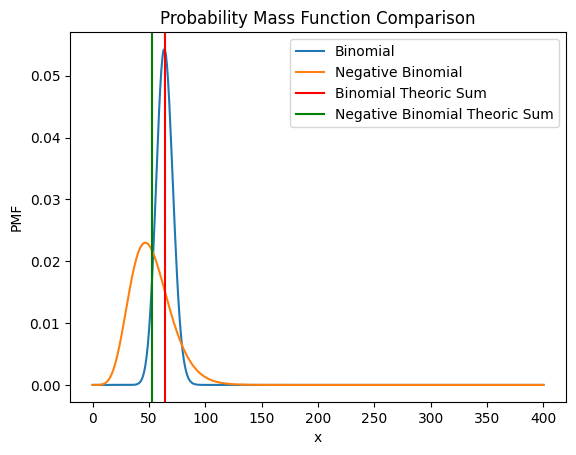

66

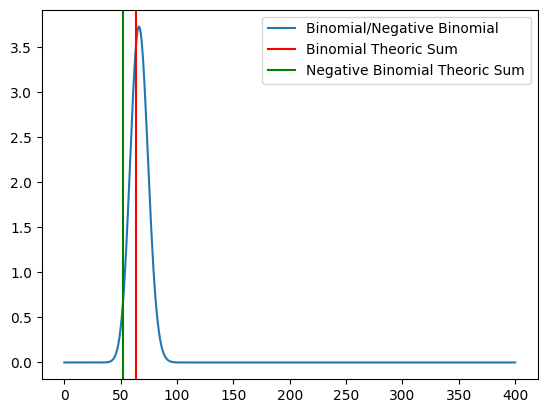

In [132]:

x = np.arange(0, N*n+1)
binom_pmf = binom.pmf(x, n*N, p)
nbinom_pmf = nbinom.pmf(x, N*r, p)

plt.plot(x, binom_pmf, label='Binomial')
plt.plot(x, nbinom_pmf, label='Negative Binomial')
plt.axvline(S_binom_theoric,color='red',label='Binomial Theoric Sum')
plt.axvline(S_nbinom_theoric,color='green',label='Negative Binomial Theoric Sum')
plt.xlabel('x')
plt.ylabel('PMF')
plt.title('Probability Mass Function Comparison')
plt.legend()
plt.show()

plt.plot(x,binom_pmf/nbinom_pmf,label='Binomial/Negative Binomial')
plt.axvline(S_binom_theoric,color='red',label='Binomial Theoric Sum')
plt.axvline(S_nbinom_theoric,color='green',label='Negative Binomial Theoric Sum')
plt.legend()
np.argmax(binom_pmf/nbinom_pmf)

# BF(y)

## Theoric

In [133]:
from scipy.special import gammaln,betaln
def log_comb(n,k):
    return gammaln(n+1)-gammaln(k+1)-gammaln(n-k+1)

def logBF_binom_nbinom(X,n,r,a,b):
    N = len(X)
    S = np.sum(X)
    diff_beta = betaln(a+S,b+n*N-S)-betaln(a+r*N,b+S)
    c1 = np.sum([log_comb(n,X[i]) for i in range(len(X))])
    c2 = np.sum([log_comb(X[i]+r-1,X[i]) for i in range(len(X))])
    logBF = diff_beta+c1-c2
    return logBF


In [134]:
a,b=1,1
logBF_theo=logBF_binom_nbinom(X_binom,n,r,a,b)
print('Theoric logBF binom/nbinom:\nfor X_binom = {}\nfor X_nbinom = {}'.format(logBF_binom_nbinom(X_binom,n,r,a,b),logBF_binom_nbinom(X_nbinom,n,r,a,b)))

Theoric logBF binom/nbinom:
for X_binom = 8.781920569004825
for X_nbinom = -3.798032606421671


## Bridge

In [135]:
from scipy.special import logsumexp
def logBF_Bridge_ratio(lratio_num, lratio_den,BF_init = 0, epsilon=0, a=0):
    logBF = [np.inf,BF_init]
    n = min(len(lratio_num),len(lratio_den))
    k=0
    while np.abs(logBF[-1]-logBF[-2])>epsilon:

        num_j = np.array([logsumexp([0,logBF[-1]+lratio_num[j]]) for j in range(n)])
        den_i = np.array([logsumexp([lratio_den[i],logBF[-1]]) for i in range(n)])
        
        num = logsumexp(-num_j)
        den = logsumexp(-den_i)

        new_logBF = num-den
        logBF.append(new_logBF)
        k+=1
        
        #print("{}. log(numerator) = {}, log(denominator) = {}, logBF = {}\n\n".format(k+1,num,den,new_logBF))
        
    return logBF[1:]

In [136]:
def sample_posterior_binom_p(n_binom,N,S,a,b,n_samples):
    return beta.rvs(a+S,b+n_binom*N-S,size=n_samples)
def sample_posterior_nbinom_p(r_nbinom,N,S,a,b,n_samples):
    return beta.rvs(a+N*r_nbinom,b+S,size=n_samples)

In [137]:
def sample_X_binom_given_S(N, S, n_binom):
    matrix = np.zeros((N, n_binom))
    random_coords = np.random.choice(N * n_binom, size=S, replace=False)
    matrix.flat[random_coords] = 1
    return np.sum(matrix, axis=1)

def sample_X_nbinom_given_S(N,S,r):
    full_vect = np.array([0]*(r*N)+[1]*S)
    index = np.random.choice(N,size=S+N*r,replace=True)   
    result = np.array([np.sum(full_vect[np.where(index==i)[0]]) for i in range(N)])
    return result

from scipy.stats import multinomial
def sample_X_given_S(S,N,T):
    return multinomial.rvs(S,[1/N]*N,size=T)

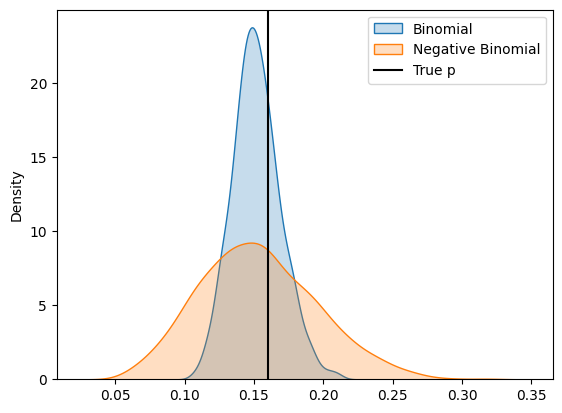

In [138]:
T=1000
post_p_binom = sample_posterior_binom_p(n,N,S_binom,a,b,T)
post_p_nbinom = sample_posterior_nbinom_p(r,N,S_binom,a,b,T)

sns.kdeplot(post_p_binom,fill=True,label='Binomial')
sns.kdeplot(post_p_nbinom,fill=True,label='Negative Binomial')
plt.axvline(p,color='k',label='True p')
plt.legend()

In [139]:
lratio_num = [np.sum(nbinom.logpmf(X_binom,r,post_p_nbinom[i])-binom.logpmf(X_binom,n,post_p_nbinom[i])) for i in range(T)]
lratio_den = [np.sum(binom.logpmf(X_binom,n,post_p_binom[i])-nbinom.logpmf(X_binom,r,post_p_binom[i])) for i in range(T)]

print("Bridge ratio logBF: {}".format(logBF_Bridge_ratio(lratio_num,lratio_den,BF_init=logBF_theo,epsilon=1e-5,a=0)[-1]))

Bridge ratio logBF: 8.783723459396908


## Comparison

100%|██████████| 1000/1000 [00:29<00:00, 33.71it/s]


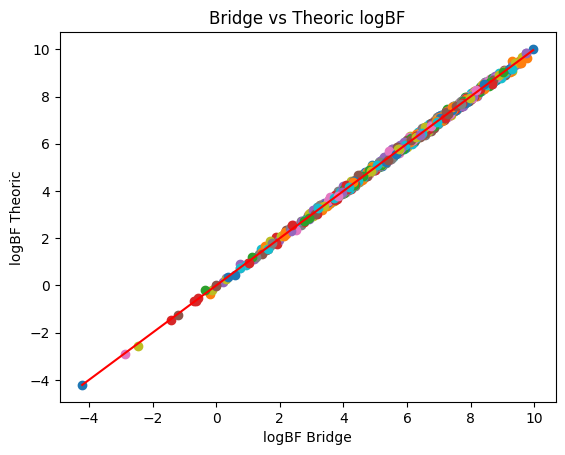

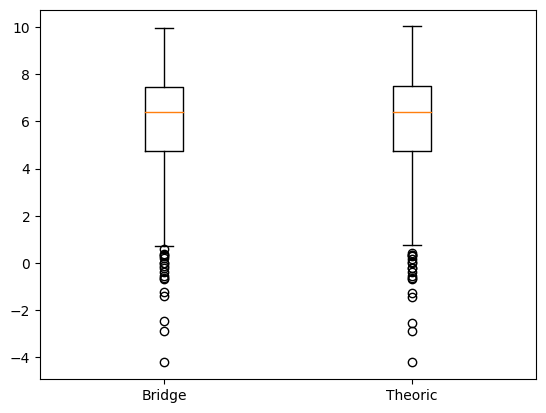

In [141]:
BF_X_binom = []
BF_theo_X_binom = []
T=100
for i in tqdm(range(1000)):
    X = test_binom[i]
    post_p_binom = sample_posterior_binom_p(n,N,S_binom,a,b,T)
    post_p_nbinom = sample_posterior_nbinom_p(r,N,S_binom,a,b,T)
    
    lratio_num = [np.sum(nbinom.logpmf(X,r,post_p_nbinom[i])-binom.logpmf(X,n,post_p_nbinom[i])) for i in (range(T))]
    lratio_denom = [np.sum(binom.logpmf(X,n,post_p_binom[i])-nbinom.logpmf(X,r,post_p_binom[i])) for i in (range(T))]
    bridge= logBF_Bridge_ratio(lratio_num,lratio_denom,epsilon=.0001)[-1]
    theo = logBF_binom_nbinom(X,n,r,a,b)
    BF_X_binom.append(bridge)
    BF_theo_X_binom.append(theo)
    plt.scatter((bridge),(theo))
plt.plot([np.min(BF_X_binom),np.max(BF_X_binom)],[np.min(BF_X_binom),np.max(BF_X_binom)],color='red')
plt.xlabel("logBF Bridge")
plt.ylabel("logBF Theoric")
plt.title("Bridge vs Theoric logBF")
plt.show()

plt.boxplot([BF_X_binom,BF_theo_X_binom],labels=['Bridge','Theoric']);

# BF(S)

In [142]:
from scipy.special import logsumexp
def logBF_Bridge_Quantile_Llike(llike1_into_1,llike1_into_2,llike2_into_1,llike2_into_2,n=100,BF_init=0,epsilon=.1,a = 0):
    logBF = [np.inf,BF_init]
    k=0
    l11 = llike1_into_1[-n:]
    l12 = llike2_into_1[-n:]
    l21 = llike1_into_2[-n:]
    l22 = llike2_into_2[-n:]
        
    
    print("l11: mean = {} min = {} max = {}".format(np.mean(l11),np.min(l11),np.max(l11)))
    print("l12: mean = {} min = {} max = {}".format(np.mean(l12),np.min(l12),np.max(l12)))
    print("l21: mean = {} min = {} max = {}".format(np.mean(l21),np.min(l21),np.max(l21)))
    print("l22: mean = {} min = {} max = {}".format(np.mean(l22),np.min(l22),np.max(l22)))
    
    print("r2 = l22-l12 : mean = {} min = {} max = {}".format(np.mean(l22-l12),np.min(l22-l12),np.max(l22-l12)))
    print("r1 = l11-l21 : mean = {} min = {} max = {}".format(np.mean(l11-l21),np.min(l11-l21),np.max(l11-l21)))
    
    while np.abs(logBF[-1]-logBF[-2])>epsilon:
        print("ITERATION {}".format(k+1))
        
        y_1 = [logsumexp([0,l22[i]-l12[i]+logBF[-1]]) for i in range(n)]
        y_2 = [logsumexp([l11[i]-l21[i],logBF[-1]]) for i in range(n)]
        
        term1 = logsumexp(y_1)
        term2 = logsumexp(y_2)
        

        new_logBF = term1-term2
        print("{}. logBF = {}\n\n".format(k+1,new_logBF))
        logBF.append(new_logBF)
        k+=1
        
    return logBF[1:]

## Theoric

In [143]:
def logBF_theo_S_binom_nbinom(S,N,n,r,a,b):
    c1 = log_comb(N*n,S)
    c2 = log_comb(S+N*r-1,S)
    diff_beta = betaln(a+S,b+N*n-S)-betaln(a+r*N,b+S)
    logBF = diff_beta+c1-c2
    #print("diff_beta: {}, c1: {}, c2: {} BF = {}".format(diff_beta,c1,c2,logBF))
    return logBF


In [144]:
print("For S = {} logBF = {}".format(S_binom,logBF_theo_S_binom_nbinom(S_binom,N,n,r,a,b)))

For S = 60 logBF = 0.21462859878974427


52.84528452845285

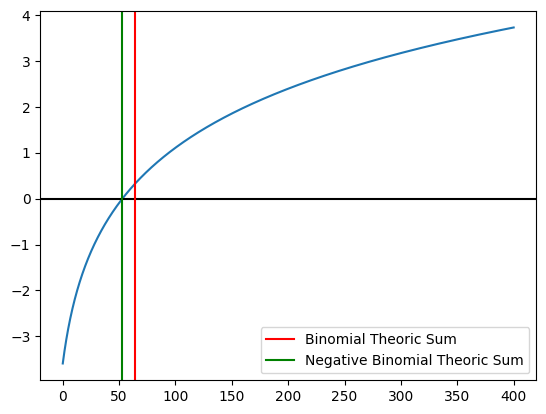

In [151]:
S_list = np.linspace(0,N*n,10000)
logBF_list = [logBF_theo_S_binom_nbinom(S,N,n,r,a,b) for S in S_list]
plt.plot(S_list,(logBF_list))
plt.axhline(0,c='k')
plt.axvline(S_binom_theoric,c='r',label='Binomial Theoric Sum')
plt.axvline(S_nbinom_theoric,c='g',label='Negative Binomial Theoric Sum')
plt.legend()
S_list[np.abs(np.array(logBF_list)).argmin()]

## Bridge

In [153]:
def X_binomm_S(n,p,S,N):
    X = binom(n,p).rvs(N)
    while np.sum(X) != S:
        X = binom(n,p).rvs(N)
    return X

In [154]:
def X_nbinomm_S(r,p,S,N,n):
    X = nbinom(r,p).rvs(N)
    while np.sum(X) != S or np.max(X)>n:
        X = nbinom(r,p).rvs(N)
    return X

## Comparison

# QU'EST CE QUE NOTRE FORMULE ESTIME ? DIFF ENTRE RATIO(X/theta_i) et RATIO(X_i/theta_i)

In [188]:
T=100000

In [189]:
X_S_binom = np.array([(X_binomm_S(n,p,S_binom,N)) for i in tqdm(range(T))])

100%|██████████| 100000/100000 [56:46<00:00, 29.36it/s]


In [190]:
X_S_nbinom = np.array([(X_nbinomm_S(r,p,S_binom,N,n)) for i in tqdm(range(T))])

100%|██████████| 100000/100000 [31:25<00:00, 53.03it/s]


In [191]:
print("Binom: mean = {} std = {} min = {} max = {}".format(np.mean(X_S_binom),np.std(X_S_binom),np.min(X_S_binom),np.max(X_S_binom)))
print("Nbinom: mean = {} std = {} min = {} max = {}".format(np.mean(X_S_nbinom),np.std(X_S_nbinom),np.min(X_S_nbinom),np.max(X_S_nbinom)))

Binom: mean = 6.0 std = 2.1459063353278025 min = 0 max = 17
Nbinom: mean = 6.0 std = 5.849818800612545 min = 0 max = 40


In [176]:
llike_binom_same_X_binom = [np.sum(binom.logpmf(X_binom,n,post_p_binom[i])) for i in range(T)]
llike_nbinom_same_X_binom = [np.sum(nbinom.logpmf(X_binom,r,post_p_binom[i])) for i in range(T)]

like_binom_same_X_nbinom = [np.sum(binom.logpmf(X_binom,n,post_p_nbinom[i])) for i in range(T)]
like_nbinom_same_X_nbinom = [np.sum(nbinom.logpmf(X_binom,r,post_p_nbinom[i])) for i in range(T)]

like_binom_X_binom = [np.sum(binom.logpmf(X_S_binom[i],n,post_p_binom[i])) for i in range(T)]
like_nbinom_X_binom = [np.sum(nbinom.logpmf(X_S_binom[i],r,post_p_binom[i])) for i in range(T)]

like_binom_X_nbinom = [np.sum(binom.logpmf(X_S_nbinom[i],n,post_p_nbinom[i])) for i in range(T)]
like_nbinom_X_nbinom = [np.sum(nbinom.logpmf(X_S_nbinom[i],r,post_p_nbinom[i])) for i in range(T)]

In [177]:
print("For the same X binom:\nlog f_binom(X_binom|p_binom) : mean = {} min = {} max = {}".format(np.mean(llike_binom_same_X_binom),np.min(llike_binom_same_X_binom),np.max(llike_binom_same_X_binom)))
print("log f_nbinom(X_binom|p_binom) : mean = {} min = {} max = {}".format(np.mean(llike_nbinom_same_X_binom),np.min(llike_nbinom_same_X_binom),np.max(llike_nbinom_same_X_binom)))
print("LRatio f_binom/f_nbinom(X_binom|p_binom) : mean = {} min = {} max = {}".format(np.mean(np.array(llike_binom_same_X_binom)-np.array(llike_nbinom_same_X_binom)),np.min(np.array(llike_binom_same_X_binom)-np.array(llike_nbinom_same_X_binom)),np.max(np.array(llike_binom_same_X_binom)-np.array(llike_nbinom_same_X_binom))))
print("\nlog f_nbinom(X_binom|p_nbinom) : mean = {} min = {} max = {}".format(np.mean(like_nbinom_same_X_nbinom),np.min(like_nbinom_same_X_nbinom),np.max(like_binom_same_X_nbinom)))
print("log f_binom(X_binom|p_nbinom) : mean = {} min = {} max = {}".format(np.mean(like_binom_same_X_nbinom),np.min(like_binom_same_X_nbinom),np.max(like_binom_same_X_nbinom)))
print('Lratio f_nbinom/f_binom(X_binom|p_nbinom) : mean = {} min = {} max = {}'.format(np.mean(np.array(like_nbinom_same_X_nbinom)-np.array(like_binom_same_X_nbinom)),np.min(np.array(like_nbinom_same_X_nbinom)-np.array(like_binom_same_X_nbinom)),np.max(np.array(like_nbinom_same_X_nbinom)-np.array(like_binom_same_X_nbinom))))



For the same X binom:
log f_binom(X_binom|p_binom) : mean = -19.576263305412226 min = -25.931198811123092 max = -19.079532440327505
log f_nbinom(X_binom|p_binom) : mean = -28.81235130872329 min = -30.16647324473424 max = -28.708142280202015
LRatio f_binom/f_nbinom(X_binom|p_binom) : mean = 9.236088003311062 min = 3.7999723809245296 max = 9.645765868858089

log f_nbinom(X_binom|p_nbinom) : mean = -29.233081390322944 min = -38.955976081286835 max = -19.079532441008848
log f_binom(X_binom|p_nbinom) : mean = -22.026385428590817 min = -83.25735624302621 max = -19.079532441008848
Lratio f_nbinom/f_binom(X_binom|p_nbinom) : mean = -7.206695961732129 min = -9.645765856286072 max = 44.301380161739374


In [178]:
print("For diff X_binom:\nlog f_binom(X_binom|p_binom) : mean = {} min = {} max = {}".format(np.mean(like_binom_X_binom),np.min(like_binom_X_binom),np.max(like_binom_X_binom)))
print("log f_nbinom(X_binom|p_binom) : mean = {} min = {} max = {}".format(np.mean(like_nbinom_X_binom),np.min(like_nbinom_X_binom),np.max(like_nbinom_X_binom)))
print("LRatio f_binom/f_nbinom(X_binom|p_binom) : mean = {} min = {} max = {}".format(np.mean(np.array(like_binom_X_binom)-np.array(like_nbinom_X_binom)),np.min(np.array(like_binom_X_binom)-np.array(like_nbinom_X_binom)),np.max(np.array(like_binom_X_binom)-np.array(like_nbinom_X_binom))))

print("\nFor diff X_nbinom:\nlog f_nbinom(X_nbinom|p_nbinom) : mean = {} min = {} max = {}".format(np.mean(like_nbinom_X_nbinom),np.min(like_nbinom_X_nbinom),np.max(like_nbinom_X_nbinom)))
print("log f_binom(X_nbinom|p_nbinom) : mean = {} min = {} max = {}".format(np.mean(like_binom_X_nbinom),np.min(like_binom_X_nbinom),np.max(like_binom_X_nbinom)))
print('Lratio f_nbinom/f_binom(X_nbinom|p_nbinom) : mean = {} min = {} max = {}'.format(np.mean(np.array(like_nbinom_X_nbinom)-np.array(like_binom_X_nbinom)),np.min(np.array(like_nbinom_X_nbinom)-np.array(like_binom_X_nbinom)),np.max(np.array(like_nbinom_X_nbinom)-np.array(like_binom_X_nbinom))))

For diff X_binom:
log f_binom(X_binom|p_binom) : mean = -22.27440454410674 min = -34.225327619872004 max = -17.478545015991045
log f_nbinom(X_binom|p_binom) : mean = -28.812351308723283 min = -30.16647324473424 max = -28.708142280202015
LRatio f_binom/f_nbinom(X_binom|p_binom) : mean = 6.537946764616544 min = -5.432973401134223 max = 11.241623529529072

For diff X_nbinom:
log f_nbinom(X_nbinom|p_nbinom) : mean = -29.233081390322944 min = -38.95597608128683 max = -28.708142322667353
log f_binom(X_nbinom|p_nbinom) : mean = -49.82744940683287 min = -138.78797749287742 max = -22.748043780899906
Lratio f_nbinom/f_binom(X_nbinom|p_nbinom) : mean = 20.59436801650993 min = -5.960307541577961 max = 106.06951651750376


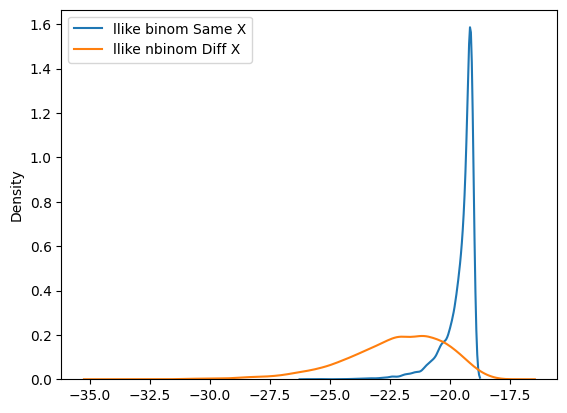

In [186]:
sns.kdeplot((llike_binom_same_X_binom),label='llike binom Same X')
sns.kdeplot((like_binom_X_binom),label='llike nbinom Diff X')
plt.legend()

In [192]:
post_p_binom = sample_posterior_binom_p(n,N,S_binom,a,b,T)
post_p_nbinom = sample_posterior_nbinom_p(r,N,S_binom,a,b,T)

100%|██████████| 100/100 [00:27<00:00,  3.58it/s]


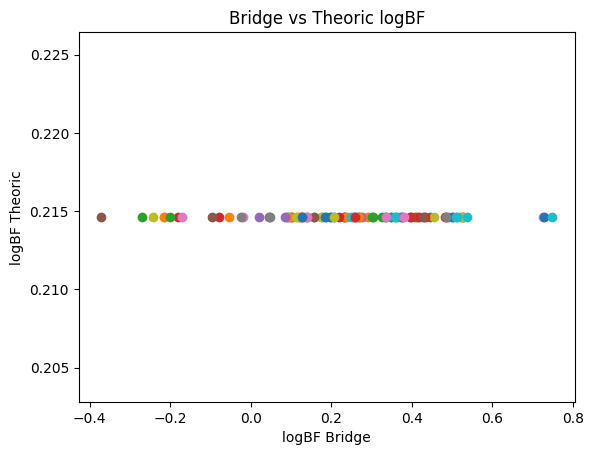

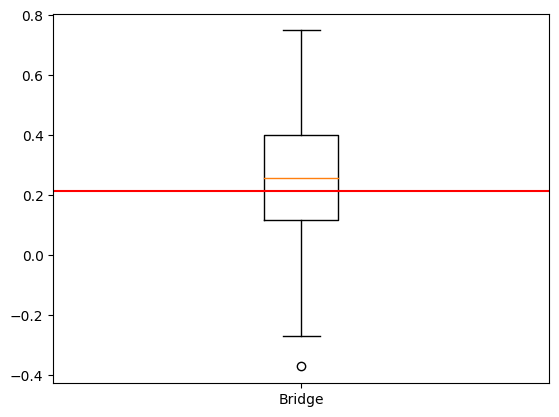

In [193]:
BF_S_binom = []
BF_theo_S_binom = []
t=1000
theo = logBF_theo_S_binom_nbinom(S_binom,N,n,r,a,b)
for j in tqdm(range(100)):

    
    
    
    lratio_num = [np.sum(nbinom.logpmf(X_S_nbinom[j*i+i],r,post_p_nbinom[(j+1)*i])-binom.logpmf(X_S_nbinom[j*i+i],n,post_p_nbinom[(j+1)*i])) for i in (range(t))]
    lratio_denom = [np.sum(binom.logpmf(X_S_binom[j*i+i],n,post_p_binom[(j+1)*i])-nbinom.logpmf(X_S_binom[j*i+i],r,post_p_binom[(j+1)*i])) for i in (range(t))]
    
    bridge= logBF_Bridge_ratio(lratio_num,lratio_denom,epsilon=.0001)[-1]
    
    
    BF_S_binom.append(bridge)
    
    
    plt.scatter(bridge,theo)
#plt.plot([np.min(BF_S_binom),np.max(BF_S_binom)],[np.min(BF_S_binom),np.max(BF_S_binom)],color='red')
plt.xlabel("logBF Bridge")
plt.ylabel("logBF Theoric")
plt.title("Bridge vs Theoric logBF")
plt.show()

plt.boxplot([BF_S_binom],labels=['Bridge']);
plt.axhline(theo,color='red',label='Theoric')